In [2]:
from pyscf import gto, scf
from afqmc import afqmc

mol = gto.M(
    atom=[("H", 0, 0, 0), ("H", 1.6, 0, 0)],
    basis='sto-6g',
    unit='Bohr',
    verbose=0 
)

nwalkers = 2000
total_time = 200
dt = 0.01
afqmc = afqmc(mol, nwalkers, total_time, dt, verbose=4)
t_lis, computed_e = afqmc.kernel()

eri :  [[[[ 0.84432044 -0.00630159]
   [-0.00630159  0.46897178]]

  [[-0.00630159  0.01039617]
   [ 0.01039617 -0.00630159]]]


 [[[-0.00630159  0.01039617]
   [ 0.01039617 -0.00630159]]

  [[ 0.46897178 -0.00630159]
   [-0.00630159  0.84432044]]]]
nuclear repulsion energy:  0.625
time = 0.000000， weight max = 1.000000, weight min = 1.000000
time = 0.010000， weight max = 1.002020, weight min = 0.974488
time = 0.020000， weight max = 1.004054, weight min = 0.961876
time = 0.030000， weight max = 1.006017, weight min = 0.963141
time = 0.040000， weight max = 1.008065, weight min = 0.958648
time = 0.050000， weight max = 1.009948, weight min = 0.957709
time = 0.060000， weight max = 1.011139, weight min = 0.959053
time = 0.070000， weight max = 1.012785, weight min = 0.960323
time = 0.080000， weight max = 1.014413, weight min = 0.961375
time = 0.090000， weight max = 1.016219, weight min = 0.951407
time = 0.100000， weight max = 1.017850, weight min = 0.949304
time = 0.110000， weight max = 1.019

In [3]:
import ipie
from ipie.analysis.autocorr import reblock_by_autocorr
import numpy as np
y = np.array(computed_e[1000:]).real
rb = reblock_by_autocorr(y, verbose=True)
print(rb)

# Reblock based on autocorrelation time
nsamples, tac = 2, 0.0
nsamples, tac = 4, 0.3306860761463071
nsamples, tac = 9, 0.7985076025739446
nsamples, tac = 18, 1.3050559056399145
nsamples, tac = 37, 3.9662923091219486
nsamples, tac = 74, 6.326736036803703
nsamples, tac = 148, 9.470205721987636
nsamples, tac = 296, 8.993306683954096
nsamples, tac = 593, 34.03294803785994
nsamples, tac = 1187, 40.28588977519031
nsamples, tac = 2375, 40.420729454701586
nsamples, tac = 4750, 30.3235794720466
nsamples, tac = 9500, 45.03418976323038
nsamples, tac = 19001, 47.0875106580764
   ETotal_ac  ETotal_error_ac  ETotal_nsamp_ac  ac
0  -1.136618         0.000087              395  48


In [4]:
from pyscf import gto, scf, fci
mf = scf.RHF(mol)
hf_energy = mf.kernel()
cisolver = fci.FCI(mf)
fci_energy = cisolver.kernel()[0]
print(fci_energy)

-1.1371168306553083


In [16]:
import numpy as np
from pyscf import gto, scf, fci
from ipie.utils.linalg import get_orthoAO
from ipie.hamiltonians.generic import Generic as HamGeneric
from ipie.qmc.afqmc import AFQMC
from ipie.systems.generic import Generic
from ipie.trial_wavefunction.single_det import SingleDet

r = 1.6  # Bohr
mol = gto.M(
    atom='H 0 0 0; H 0 0 {}'.format(r),
    basis="sto-6g",
    verbose=3,
    unit="Bohr",
    spin=0
)
mf = scf.RHF(mol).run()

cisolver = fci.FCI(mf)
fci_energy = cisolver.kernel()[0]
print('fci', fci_energy)

from ipie.utils.from_pyscf import (
    generate_integrals,
)

s1e = mol.intor("int1e_ovlp_sph")
X = get_orthoAO(s1e)

h1e, chol, e0 = generate_integrals(mol, mf.get_hcore(), X)

xinv = np.linalg.inv(X)

# Build uhf trial to compute the force bias, in a less accurate but cheaper way, tricky.
psi_a = xinv.dot(mf.mo_coeff[:, :mol.nelec[0]])
psi_b = xinv.dot(mf.mo_coeff[:, :mol.nelec[0]])

num_basis = mf.mo_coeff[0].shape[-1]
system = Generic(nelec=mol.nelec)
num_chol = chol.shape[0]
ham = HamGeneric(
    np.array([h1e, h1e]),
    chol.transpose((1, 2, 0)).reshape((num_basis * num_basis, num_chol)),
    e0
)

trial = SingleDet(np.hstack([psi_a, psi_b]), mol.nelec, num_basis)
trial.build()
trial.half_rotate(ham)



from ipie.walkers.uhf_walkers import UHFWalkers
num_walkers = 200
walkers = UHFWalkers(np.hstack([psi_a, psi_b]), system.nup, system.ndown, ham.nbasis, num_walkers)

seed = 114514
afqmc = AFQMC.build(
        mol.nelec,
        ham,
        trial,
        walkers=walkers,
        num_walkers=num_walkers,
        seed=seed,
        num_steps_per_block=25,
        num_blocks=800,
        timestep=0.01,
        stabilize_freq=5,
        pop_control_freq=5,
        verbose=True)

afqmc.run()
afqmc.finalise(verbose=True)

from ipie.analysis.extraction import extract_observable
qmc_data = extract_observable(afqmc.estimators.filename, "energy")
y = qmc_data["ETotal"]
#y = y[1:]  # discard first 1 block

from ipie.analysis.autocorr import reblock_by_autocorr
df = reblock_by_autocorr(y[40:])
print(df)

converged SCF energy = -1.11134971410867
fci -1.1371168306553083
# random seed is 114514
# Using pair_branch population control algorithm.
# target weight is 200
# total weight is 200
# ipie version: 0.6.2
# Git hash: 85092269b29f9b9cbc215788dce77e3b8e8970c2-dirty.
# Git branch: develop.
# Found uncommitted changes and/or untracked files.
# Modified : ipie/propagation/phaseless_base.py
# Modified : ipie/trial_wavefunction/single_det.py
# Modified : ipie/trial_wavefunction/wavefunction_base.py
# Modified : ipie/walkers/uhf_walkers.py
# Calculation uuid: 8bdce0d2-61f6-11ee-870b-86f963750f54.
# Approximate memory available per node: 16.0000 GB.
# Running on 1 MPI rank.
# Root processor name: dhcp-10-250-76-62.harvard.edu
# Python interpreter: 3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]
# Using numpy v1.24.3 from: /Applications/anaconda3/lib/python3.11/site-packages/numpy.
# - BLAS lib: openblas openblas
# - BLAS dir: /Applications/anaconda3/lib
# Using scipy v1.10.1 from: /Applic

/Applications/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: divide by zero encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Applications/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


                1   2.0166894537344524e+02  2.0360766599779654e+02 -4.3355544252405670e-01 -2.2377795107388226e+02  2.0000000000000000e+02 -1.1188897553694113e+00 -1.7657888081789506e+00  6.4689905280953919e-01
                2   2.0002595012015519e+02  2.0070948703170285e+02 -4.3808381973065924e-01 -2.2461095071702826e+02  2.0000000000000000e+02 -1.1230547535851414e+00 -1.7657888081789508e+00  6.4273405459380939e-01
                3   2.0002193073463576e+02  2.0004299081090872e+02 -4.4167163892931743e-01 -2.2511943555830103e+02  2.0000000000000000e+02 -1.1255971777915053e+00 -1.7657888081789508e+00  6.4019163038744542e-01
                4   2.0002149396326163e+02  2.0005089171334851e+02 -4.4724110909862363e-01 -2.2562500738893766e+02  2.0000000000000000e+02 -1.1281250369446882e+00 -1.7657888081789508e+00  6.3766377123426221e-01
                5   1.9998039279840691e+02  1.9997753140650866e+02 -4.4337431453771980e-01 -2.2611046157846579e+02  2.0000000000000000e+02 -1.13055230789232

/Users/formic/ipie/ipie/analysis/autocorr.py:92: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tacs += [autocorr_gw2010(y[:n])]
/Users/formic/ipie/ipie/analysis/autocorr.py:107: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yblocked += [numpy.mean(y[offset : offset + block_size])]
/Users/formic/ipie/ipie/analysis/autocorr.py:105: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* index

In [21]:
from ipie.analysis.extraction import extract_observable
qmc_data = extract_observable(afqmc.estimators.filename, "energy")
y = qmc_data["ETotal"]
y = y[40:]  # discard first 1 block

from ipie.analysis.autocorr import reblock_by_autocorr
df = reblock_by_autocorr(y,verbose=True)
print(df)

# Reblock based on autocorrelation time
nsamples, tac = 2, 0.0
nsamples, tac = 5, -0.3408967984899868
nsamples, tac = 11, -0.000432866456780312
nsamples, tac = 23, 1.901056092446339
nsamples, tac = 47, 2.2909954121071356
nsamples, tac = 95, 2.7822917962178435
nsamples, tac = 190, 3.495965618008115
nsamples, tac = 380, 3.1092755002785184
nsamples, tac = 761, 3.1407805704719607
   ETotal_ac  ETotal_error_ac  ETotal_nsamp_ac  ac
0  -1.136359         0.000356              190   4


/Users/formic/ipie/ipie/analysis/autocorr.py:92: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tacs += [autocorr_gw2010(y[:n])]
/Users/formic/ipie/ipie/analysis/autocorr.py:107: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yblocked += [numpy.mean(y[offset : offset + block_size])]
/Users/formic/ipie/ipie/analysis/autocorr.py:105: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* index

/Applications/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


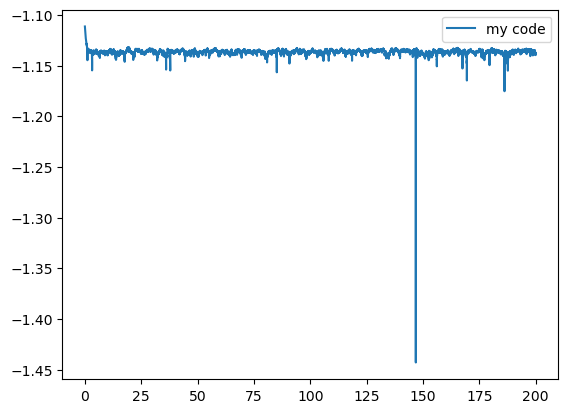

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

f = h5py.File("/Users/formic/codes/python/afqmc_tutorial-master/energy2.h5", "r")
time1 = np.asarray(f['t'])
energy1 = np.asarray(f["energy"])

nblock = np.array([x for x in range(0, 4996)])
plt.plot(np.array(t_lis), computed_e)
#plt.plot(nblock*dt, qmc_data["ETotal"])
#plt.plot(time1, energy1)
plt.legend(['my code', 'ipie', 'Tong\'s AFQMC'])